In [21]:
# Import nMPyc package
import nmpyc

# Define system parameters
nx = 5 # dimension of state
nu = 1 # dimension of control
system_type = 'continuous' # system type: continuous or discrete
sampling_rate = 0.5 # sampling rate h (optional)
t0 = 0. # initial time (optional)
method = 'cvodes' # integrator (optinal)

# Define MPC parameters
N = 15 # MPC horizon
K = 50 # MPC itertaions
x0 = nmpyc.array([0.3,0.1,0.1,297,297]) # initial value
 
discount = 1. # dicount factor (optional)


Q_batt = 6000;  # A.sec of the battery   #100 Ahr=6000As
R1 = 0.0155 #ohms
C1 = 166.8685/R1
R2 = 0.0155 
C2 = C1
R0 =  0.0121 #Ohms
Cc = 62.7  #JK-1
Ru = 3.19  #Kelvin/W
Cs = 4.5
Rc = 1.94
Tair = 297

# Define right hand side of the system dynamics
def f(t, x, u):
    y = nmpyc.array(nx);
    Vocv = 14.7958*pow(x[0],6)-36.6148 * pow(x[0],5) + 29.2355 * pow(x[0],4) -6.2817 * pow(x[0],3) - 1.6476 * pow(x[0],2) + 1.2866 * x[0] + 3.4049
    Vbatt = Vocv - x[1]-x[2] - R0*u[0];
    Qgen = u[0] * (Vocv - Vbatt);
    y[0] = -1/Q_batt * u[0];
    y[1] = -1/(R1*C1) * x[1] + 1/C1 * u[0];
    y[2] = -1/(R2*C2) * x[2] + 1/C2 * u[0];
    y[3] =  Qgen/Cc + 1/(Rc*Cc) * (x[4]-x[3]);
    y[4] = (-1/(Ru*Cs) - 1/(Rc*Cs))*x[4] + 1/(Rc*Cs)*x[3] + 1/(Ru * Cs) * Tair;
    return y

# Initialize system dynamics
system = nmpyc.system(f, nx, nu, system_type, sampling_rate, t0, method)

# Define stage cost
def l(t, x, u):
    cost = 1-x[0];
    return cost

# Define terminal cost (optional)
def F(t, x):
    return 0

# Initialize objective
objective = nmpyc.objective(l)

# Define constraints
constraints = nmpyc.constraints()

# Add bounds (optional)
lbx = nmpyc.array([0, -4.2, -4.2, 253, 253]) # lower bound for states
constraints.add_bound('lower', 'state', lbx)
ubx = nmpyc.array([1, 4.2, 4.2, 323, 323]) # upper bound for states
constraints.add_bound('upper', 'state', ubx)
lbu = nmpyc.array([-150]) # lower bound for control
constraints.add_bound('lower', 'control', lbu)
ubu =  nmpyc.array([150]) # upper bound for control
constraints.add_bound('upper', 'control', ubu)


# Initialize model
model = nmpyc.model(objective, system, constraints)

# Start MPC loop
result = model.mpc(x0, N, K, discount)



Initialize solver ...
... DONE
STARTING MPC-LOOP: (initial value: [[3.00e-01 1.00e-01 1.00e-01 2.97e+02 2.97e+02]])
... finished iteration 1 of 50 (time: 0.7087283134460449)
   ... feedback: [[-149.99999897]]
   ... closed loop state: [[3.12500000e-01 9.27448056e-02 9.27448056e-02 2.98936661e+02
  2.97054269e+02]]
... finished iteration 2 of 50 (time: 0.8858683109283447)
   ... feedback: [[-149.99999864]]
   ... closed loop state: [[3.25000000e-01 8.55113217e-02 8.55113217e-02 3.00883111e+02
  2.97209974e+02]]
... finished iteration 3 of 50 (time: 0.9917378425598145)
   ... feedback: [[-150.00000029]]
   ... closed loop state: [[3.37500000e-01 7.82994817e-02 7.82994817e-02 3.02839654e+02
  2.97458729e+02]]
... finished iteration 4 of 50 (time: 0.9166030883789062)
   ... feedback: [[-149.99999755]]
   ... closed loop state: [[3.50000000e-01 7.11092193e-02 7.11092193e-02 3.04806564e+02
  2.97792904e+02]]
... finished iteration 5 of 50 (time: 0.973876953125)
   ... feedback: [[-149.999996

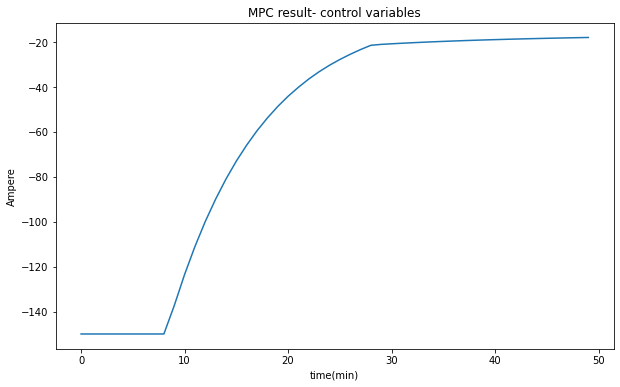

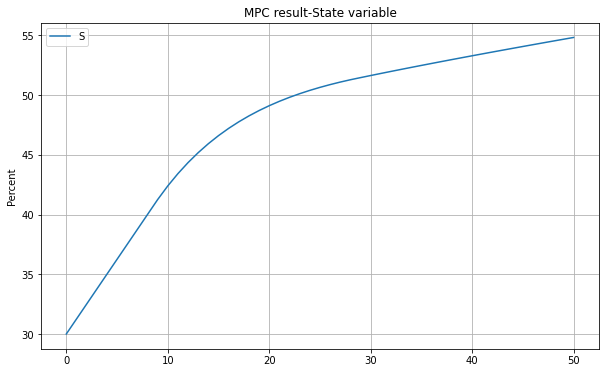

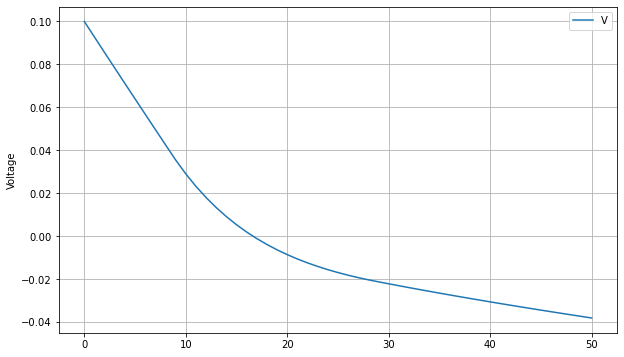

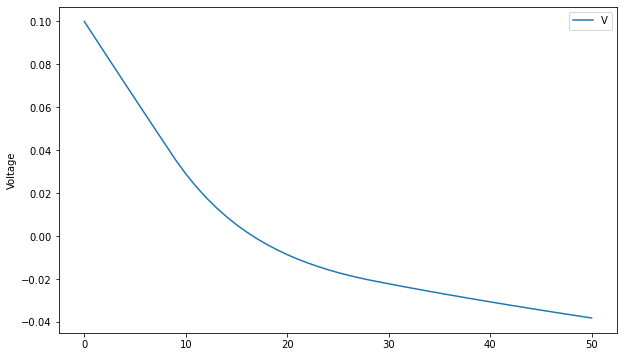

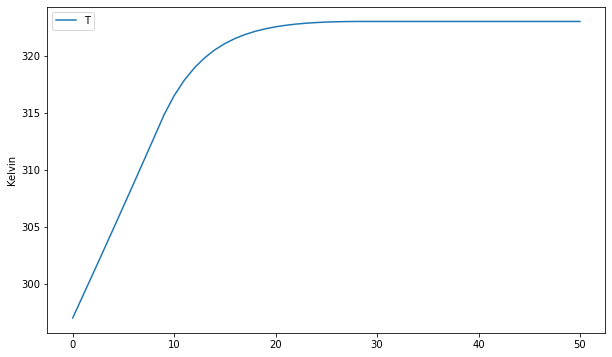

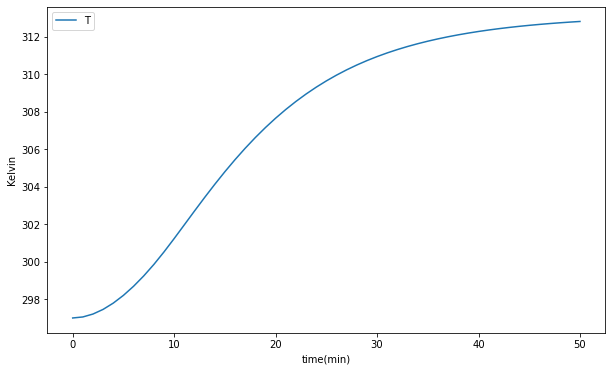

In [22]:
# Plot results

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]
plt.figure()
plt.title('MPC result- control variables')
plt.xlabel('time(min)')
plt.ylabel('Ampere')
plt.plot(result.u_cl[0,:])

plt.figure()
plt.title('MPC result-State variable')
plt.plot(100*result.x_cl[0,:])
plt.legend(labels="SOC")
plt.ylabel('Percent')
plt.grid(1)
plt.figure()
plt.plot(result.x_cl[1,:])
plt.legend('V1')
plt.ylabel('Voltage')
plt.grid(1)
plt.figure()
plt.plot(result.x_cl[2,:])
plt.legend('V2')
plt.ylabel('Voltage')
plt.figure()
plt.plot(result.x_cl[3,:])
plt.legend('Tc')
plt.ylabel('Kelvin')
plt.figure()
plt.plot(result.x_cl[4,:])
plt.legend('Ts')
plt.ylabel('Kelvin')
plt.xlabel('time(min)');

In [4]:
result.x_cl[3,:]


array([297.        , 296.99792036, 296.99608578, 296.99449417,
       296.99314356, 296.99203205, 296.99115784, 296.99051919,
       296.99011442, 296.98994193, 296.99000016, 296.99028763,
       296.99080287, 296.99154447, 296.99251107, 296.99370134,
       296.99511396, 296.99674769, 296.99860126, 297.00067348,
       297.00296315, 297.0054691 , 297.00819019, 297.01112528,
       297.01427326, 297.01763304, 297.02120355, 297.02498371,
       297.02897247, 297.03316879, 297.03757164, 297.04218001,
       297.04699288, 297.05200925, 297.05722814, 297.06264856,
       297.06826953, 297.0740901 , 297.0801093 , 297.08632617,
       297.09273978, 297.09934917, 297.10615342, 297.1131516 ,
       297.12034277, 297.12772603, 297.13530045, 297.14306513,
       297.15101917, 297.15916166, 297.16749171])